In [1]:
from common import *
from pandas.api.types import CategoricalDtype
import warnings 
warnings.filterwarnings('ignore')
debug = O()
%matplotlib inline
canvas(12,12)

In [2]:
M = pd.read_pickle(top_dir+'data/given/M.pkl')
#N = pd.read_pickle(top_dir+'data/given/N0.pkl')
#test = pd.read_pickle(top_dir+'data/given/test.pkl')

In [3]:
assetCodeSeries = pd.Series(M.assetCode.unique())
numAssetCode = len(assetCodeSeries)
#assetCodeCategorical = CategoricalDtype(assetCodeSeries, ordered=False)
#assetCodeSeries = assetCodeSeries.astype(assetCodeCategorical)
assetCodeIdMap = {x: i for i,x in enumerate(assetCodeSeries)}
#assetCodeIndex = pd.Index(assetCodeSeries)
#assetCodeIndexedDf = assetCodeIndex.to_frame().drop(0,axis=1)

assetNameSeries = pd.Series(M.assetName.unique())
numAssetName = len(assetNameSeries)
#assetNameCategorical = CategoricalDtype(assetNameSeries, ordered=False)
#assetNameSeries = assetNameSeries.astype(assetNameCategorical)
assetNameIdMap = {x: i for i,x in enumerate(assetNameSeries)}
#assetNameIndex = pd.Index(assetNameSeries)
#assetNameIndexedDf = assetNameIndex.to_frame().drop(0,axis=1)

In [4]:
returns_columns = {
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'cc0', 'returnsOpenPrevMktres1':'oo0',
    'returnsClosePrevRaw10':'cc_10','returnsOpenPrevRaw10':'oo_10',
    'returnsClosePrevMktres10':'cc0_10','returnsOpenPrevMktres10':'oo0_10'
}
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter'
]
column_filter = lambda c: c not in returns_columns and c not in excluded_columns

In [5]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
shortterm = 21
longterm = 250

In [6]:
def add_basic_features(*,M):
    M['assetCodeId'] = M.assetCode.map(assetCodeIdMap)
    M['assetNameId'] = M.assetName.map(assetNameIdMap)
    for orig_col, new_col in returns_columns.items():
        M[new_col] = np.log(M[orig_col]+1)
    # time features
    M['dayOfYear'] = M.time.dt.dayofyear
    M['dayOfWeek'] = M.time.dt.dayofweek

In [7]:
add_basic_features(M=M)

In [7]:
list(zip(N.columns,N.dtypes))

[('time', datetime64[ns, UTC]),
 ('sourceTimestamp', datetime64[ns, UTC]),
 ('firstCreated', datetime64[ns, UTC]),
 ('sourceId', dtype('O')),
 ('headline', dtype('O')),
 ('urgency', dtype('int8')),
 ('takeSequence', dtype('int16')),
 ('provider', dtype('O')),
 ('subjects', dtype('O')),
 ('audiences', dtype('O')),
 ('bodySize', dtype('int32')),
 ('companyCount', dtype('int8')),
 ('headlineTag', dtype('O')),
 ('marketCommentary', dtype('bool')),
 ('sentenceCount', dtype('int16')),
 ('wordCount', dtype('int32')),
 ('assetCodes', dtype('O')),
 ('assetName', dtype('O')),
 ('firstMentionSentence', dtype('int16')),
 ('relevance', dtype('float32')),
 ('sentimentClass', dtype('int8')),
 ('sentimentNegative', dtype('float32')),
 ('sentimentNeutral', dtype('float32')),
 ('sentimentPositive', dtype('float32')),
 ('sentimentWordCount', dtype('int32')),
 ('noveltyCount12H', dtype('int16')),
 ('noveltyCount24H', dtype('int16')),
 ('noveltyCount3D', dtype('int16')),
 ('noveltyCount5D', dtype('int16'))

In [31]:
aNames = M.groupby('assetNameId').assetCodeId.apply(set).map(len)

In [44]:
guy = aNames[aNames==2]
guy.index = guy.index.map(assetNameSeries)

In [49]:
N.shape

(9328750, 34)

In [53]:
N.columns

Index(['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'urgency',
       'takeSequence', 'provider', 'bodySize', 'companyCount', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'assetName',
       'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'assetCodesCount', 'subjectsCount', 'audiencesCount'],
      dtype='object')

In [8]:
W = O()
W.oo_10 = M[['time','assetCodeId','oo_10']].pivot('time','assetCodeId').oo_10
assert W.oo_10.columns.is_monotonic_increasing

In [9]:
C = O()
C.oo_10 = np.corrcoef(W.oo_10.fillna(0), rowvar=False)

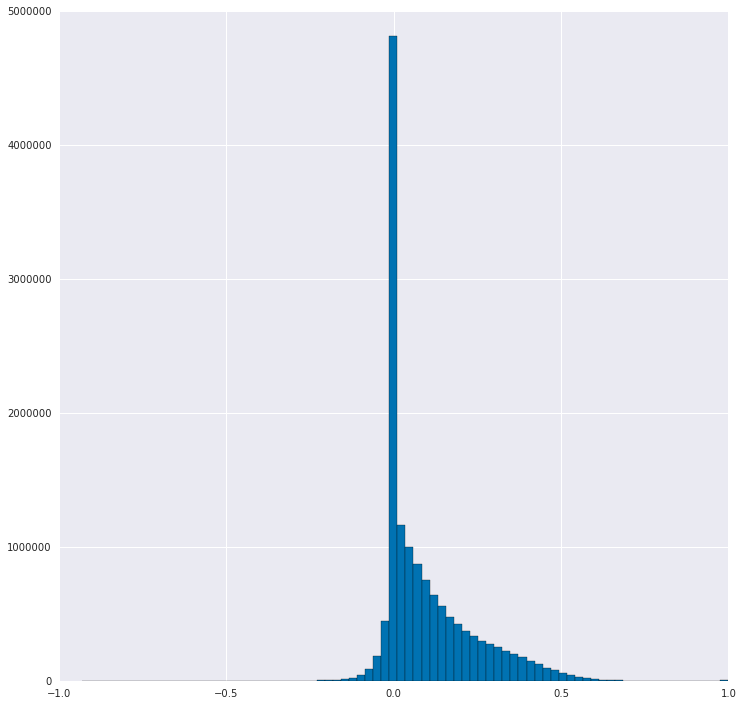

In [10]:
plt.hist(C.oo_10.flatten(), bins=80);

In [11]:
from sklearn.manifold import TSNE
vis = TSNE(n_components=2, perplexity=10, n_iter=1000, metric='precomputed').fit_transform((1-C.oo_10)**4)

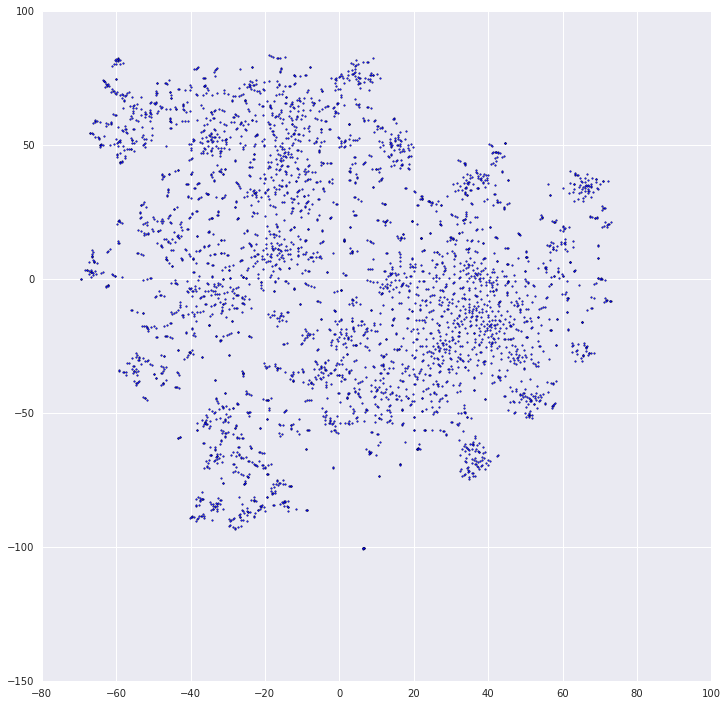

In [12]:
plt.scatter(vis[:, 0], vis[:, 1], s=3, alpha=.9);

In [9]:
import pickle
with open('hi.txt', 'wb') as file:
    pickle.dump("hi", file)

In [23]:
lim = 80

In [24]:
from __future__ import print_function

# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import sys
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold

print(__doc__)



symbols = assetCodeSeries.iloc[:lim]

# The daily variations of the quotes are what carry most information
variation = None


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV(cv=5)

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = W.oo_10.iloc[:,:lim].fillna(0).values
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
with open('labels.pkl', 'wb') as file:
    pickle.dump(labels, file)
    
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(symbols[labels == i])))



Automatically created module for IPython interactive environment
Cluster 1: ABD.N
Cluster 2: ABV.N
Cluster 3: ABY.N, AD.N, AEA.N, AFR.N, ALO.N
Cluster 4: ACTS.O
Cluster 5: ADI.N, AET.N
Cluster 6: AEOS.O
Cluster 7: ABT.N, AEE.N, AEP.N
Cluster 8: AES.N
Cluster 9: AAP.N, ABC.N, ABM.N, ADM.N, ADP.N, AF.N, AFFX.O, AFG.N, AFL.N, AHL.N, AINV.O, AJG.N, ALD.N, ALK.N, ALL.N, AMED.O, AMGN.O
Cluster 10: AGE.N, AH.N
Cluster 11: AHG.N
Cluster 12: AHS.N
Cluster 13: AAI.N, AAPL.O, ABB.N, ACF.N, ACH.N, ADBE.O, ADCT.O, ADTN.O, AHT.N, AIN.N, AIR.N, AKAM.O, AKS.N, ALB.N, ALTR.O, ALU.N, ALV.N, AMD.N, AME.N, AMKR.O
Cluster 14: A.N, ACL.N, ACS.N, ACXM.O, ADS.N, ADSK.O, AEG.N, AEIS.O, AEL.N, AER.N, AG.N, AGN.N, AGU.N, AIT.N, AIV.N, AIZ.N, AKR.N, ALGN.O, ALNY.O, ALXN.O, AMAT.O, AMG.N, AMLN.O, AMMD.O


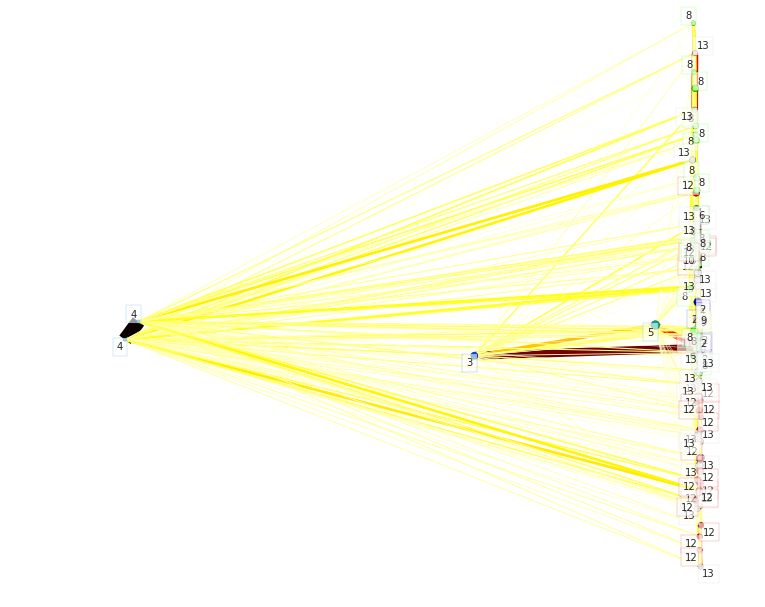

In [25]:
# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T
with open('embedding.pkl', 'wb') as file:
    pickle.dump(labels, file)

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (symbol, label, (x, y)) in enumerate(
        zip(symbols, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, label, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()